Connecting the colab to google drive

In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


Importing necessary packages

In [0]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True


In [0]:

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    root_captioning = "/content/drive/My Drive/lol/text"
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


Cleaning extra whitespaces,punctuations etc from flickr8k captions dataset

In [0]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [0]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8763
32


In [0]:

img = glob.glob(os.path.join(root_captioning,'../images/Flicker8k_Dataset', '*.jpg'))

In [0]:
len(img)


8091

In [0]:
train_images_path = os.path.join(root_captioning,'Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)

In [0]:
print(len(train_images))
print(len(test_images))


6000
1000


In [0]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [0]:
len(train_descriptions)


6000

In [0]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

In [0]:
encode_model.summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 149, 149, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 149, 149, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 149, 149, 32) 0           batch_normalization_282[0][0]    
____________________________________________________________________________________________

In [0]:
def encodeImage(img):
  
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  
  x = np.expand_dims(x, axis=0)
  
  x = preprocess_input(x)
  
  x = encode_model.predict(x)
  
  x = np.reshape(x, OUTPUT_DIM )
  return x

Preparing training dataset

In [0]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'../images/Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

Preparing testing dataset

In [0]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'../images/Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

In [0]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [0]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [0]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [0]:
max_length +=2
print(max_length)

34


In [0]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
    
      for desc in desc_list:
        
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
      
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [0]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:23, 16757.99it/s]

Found 400000 word vectors.


Building the neural network

In [0]:
embedding_dim = 200


embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape


(1652, 200)

In [0]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [0]:
embedding_dim


200

In [0]:
caption_model.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 200)      330400      input_12[0][0]                   
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 2048)         0           input_11[0][0]                   
____________________________________________________________________________________________

In [0]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

Training the dataset

In [0]:
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)

In [0]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Testing the model with flickr8k test images

/content/drive/My Drive/lol/text/../images/Flicker8k_Dataset/384577800_fc325af410.jpg


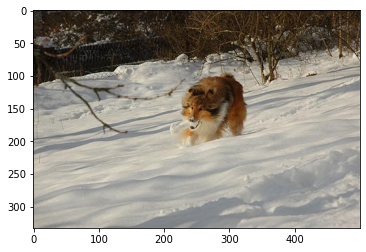

Caption: dog running through the snow
_____________________________________
/content/drive/My Drive/lol/text/../images/Flicker8k_Dataset/387830531_e89c192b92.jpg


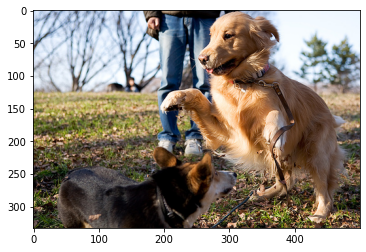

Caption: two dogs are playing with each other in the grass
_____________________________________
/content/drive/My Drive/lol/text/../images/Flicker8k_Dataset/391579205_c8373b5411.jpg


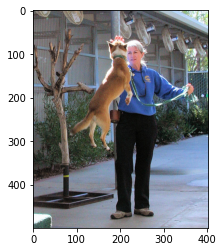

Caption: man in black shirt and jeans stands on the sidewalk
_____________________________________
/content/drive/My Drive/lol/text/../images/Flicker8k_Dataset/396360611_941e5849a3.jpg


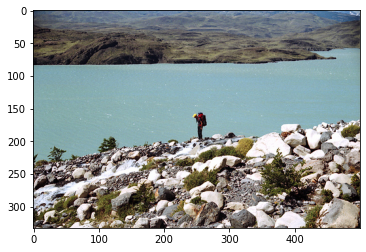

Caption: man and woman walk on the beach
_____________________________________
/content/drive/My Drive/lol/text/../images/Flicker8k_Dataset/398662202_97e5819b79.jpg


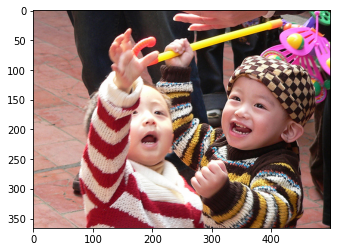

Caption: little girl in pink dress is picking on swing
_____________________________________
/content/drive/My Drive/lol/text/../images/Flicker8k_Dataset/400851260_5911898657.jpg


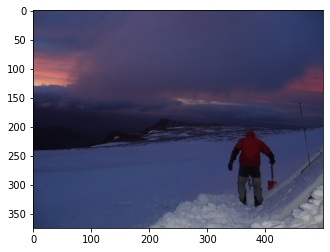

Caption: two people are climbing up snowy mountain
_____________________________________
/content/drive/My Drive/lol/text/../images/Flicker8k_Dataset/401079494_562454c4d6.jpg


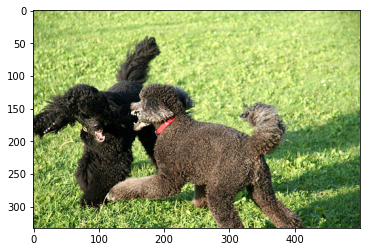

Caption: black poodle with red ribbon on its head is running through the grass
_____________________________________
/content/drive/My Drive/lol/text/../images/Flicker8k_Dataset/405615014_03be7ef618.jpg


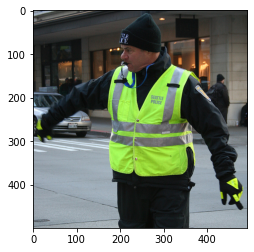

Caption: man in black shirt and cap is walking in the street
_____________________________________
/content/drive/My Drive/lol/text/../images/Flicker8k_Dataset/410453140_5401bf659a.jpg


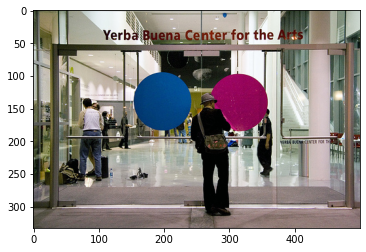

Caption: woman in red shirt and black pants walks down the street
_____________________________________
/content/drive/My Drive/lol/text/../images/Flicker8k_Dataset/415793623_6c1225ae27.jpg


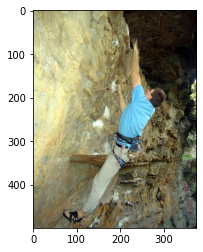

Caption: man climbing rock wall
_____________________________________


In [0]:
for z in range(10):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'../images/Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'../images/Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

Testing the model with images from google

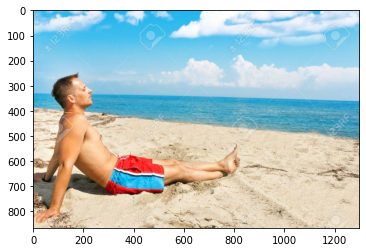

(1, 2048)
Caption: young girl in pink bathing suit is walking along the beach
_____________________________________


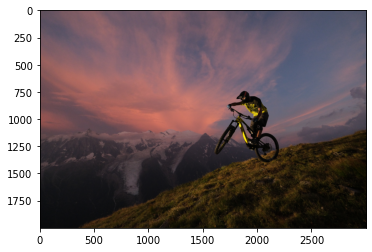

(1, 2048)
Caption: man in blue helmet riding bike
_____________________________________


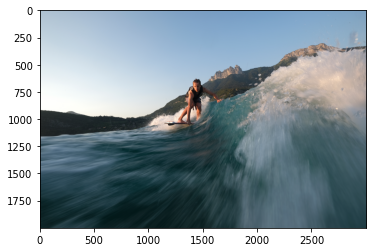

(1, 2048)
Caption: man is snowboarding on snowy hill
_____________________________________


In [0]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

urls = [
  "https://previews.123rf.com/images/luckybusiness/luckybusiness1105/luckybusiness110500111/9517300-handsome-man-enjoying-in-sun-on-the-beach.jpg?raw=true",
  "https://dl.fujifilm-x.com/global/products/cameras/x-t3/sample-images/ff_x_t3_002.JPG?raw=true",
  "https://dl.fujifilm-x.com/global/products/cameras/x-t3/sample-images/ff_x_t3_003.JPG?raw=true",



  
]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  response = requests.get(url)

  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")